In [9]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing

In [10]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

## generate file

In [7]:
pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

# file_list = [f for f in Path(pred_path).glob("*og*.csv") if "reduced" not in f.name]
# for f in file_list:
#     # data = pd.read_csv(f.resolve(), header=None)
#     sample = f.name.split('.')[0]
#     print('='*10,sample,'='*10)
#     data_x,data_y = feature_selection(f.resolve())
#     res = pd.DataFrame(data_x)
#     res["result"] = data_y
#     res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

========== Dog_1 ==========
Number of Observation(raw): 8064
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Dog_2 ==========
Number of Observation(raw): 8670
Number of features(raw): 192
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Dog_3 ==========
Number of Observation(raw): 24192
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Dog_4 ==========
Number of Observation(raw): 14424
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Dog_5 ==========
Number of Observation(raw): 7680
Number of features(raw): 180
Fitting 5 folds for each of 20 candidates, totalling 100 fits


## functions 

In [8]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        gradient_boosting = GradientBoostingClassifier(n_estimators=200,max_features='log2').fit(X_train, y_train)
#         y_pred = gradient_boosting.predict(X_test)
                
        y_hat = gradient_boosting.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = gradient_boosting.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(gradient_boosting, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, gradient_boosting.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "gbdt_rocaoc_dect_{}.pdf".format(save)))
    plt.show()
    return aucs


## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9861     ,    0.9958     ,    1.0000     ,    0.9930     
  1  ,    0.9940     ,    1.0000     ,    0.9958     ,    0.9861     ,    0.9930     
  1  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9718     ,    0.9916     ,    1.0000     ,    0.9857     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.9760     ,    1.0000     ,    0.9832     ,    0.9467     ,    0.9726     
  4  ,    0.9820     ,    0.9718     ,    0.9790     ,    0.9583     ,    0.9650     
              prec

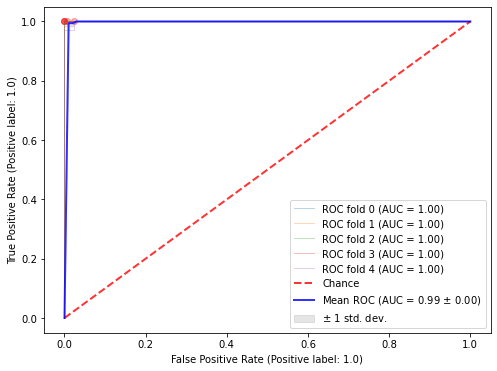

[1.0, 0.9999161636485581, 1.0, 1.0, 0.9993252930758202]
0.9998482913448756
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9847     ,    1.0000     ,    0.9867     ,    0.9079     ,    0.9517     
  0  ,    1.0000     ,    0.9710     ,    0.9962     ,    1.0000     ,    0.9853     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9956     ,    1.0000     ,    0.9962     ,    0.9718     ,    0.9857     
  2  ,    0.9978     ,    0.9710     ,    0.9943     ,    0.9853     ,    0.9781     
  3  ,    0.9956     ,    1.0000     ,    0.9962     ,    0.9718     ,    0.9857     
  3  ,    0.9935     ,    1.0000     ,    0.9943     ,    0.9583     ,    0.9787     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.9978     ,    1.0

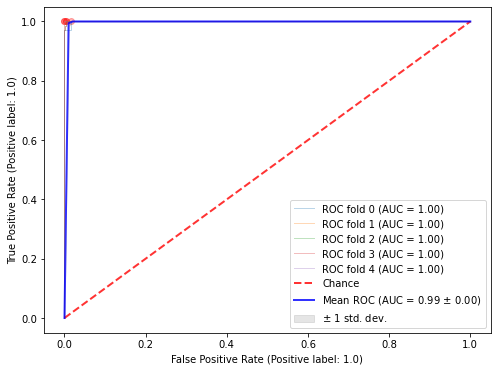

[0.9995579552271795, 1.0, 0.9999052761201099, 0.9999052761201099, 1.0]
0.9998737014934799
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9984     ,    0.9948     ,    0.9981     ,    0.9845     ,    0.9896     
  0  ,    0.9979     ,    0.9948     ,    0.9976     ,    0.9795     ,    0.9871     
  1  ,    0.9995     ,    0.9844     ,    0.9981     ,    0.9947     ,    0.9895     
  1  ,    0.9958     ,    0.9844     ,    0.9948     ,    0.9594     ,    0.9717     
  2  ,    0.9916     ,    0.9948     ,    0.9919     ,    0.9227     ,    0.9574     
  2  ,    0.9916     ,    0.9844     ,    0.9909     ,    0.9220     ,    0.9521     
  3  ,    0.9926     ,    0.9948     ,    0.9928     ,    0.9317     ,    0.9622     
  3  ,    0.9953     ,    0.9896     ,    0.9948     ,    0.9548     ,    0.9719     
  4  ,    0.9837     ,    0.9844     ,    0.9838     ,    0.8591     ,    0.9175     
  4  ,    0.99

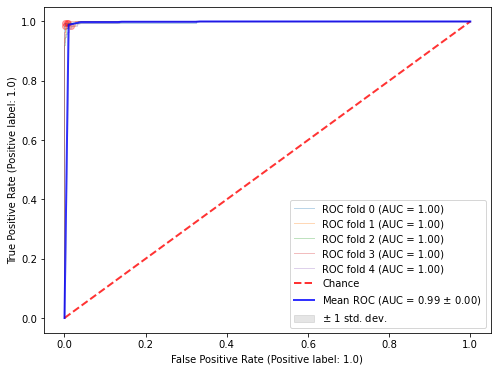

[0.9983040091036415, 0.9995677958683473, 0.9995431766456583, 0.9998413427871149, 0.9986514136904763]
0.9991815476190476
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9903     ,    0.9992     ,    1.0000     ,    0.9951     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9903     ,    0.9992     ,    1.0000     ,    0.9951     
  2  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  2  ,    0.9991     ,    0.9903     ,    0.9984     ,    0.9903     ,    0.9903     
  3  ,    0.9892     ,    1.0000     ,    0.9902     ,    0.8957     ,    0.9450     
  3  ,    0.9982     ,    0.9709     ,    0.9959     ,    0.9804     ,    0.9756     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

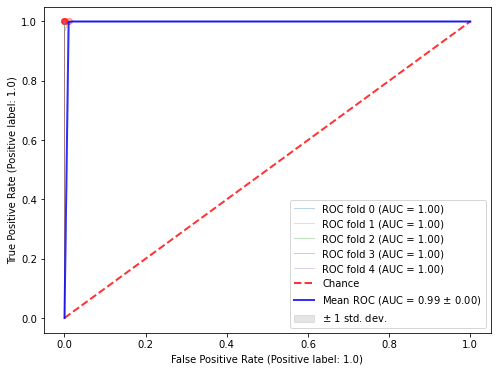

[1.0, 1.0, 0.9999913004141002, 0.999852107039705, 1.0]
0.999968681490761
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1

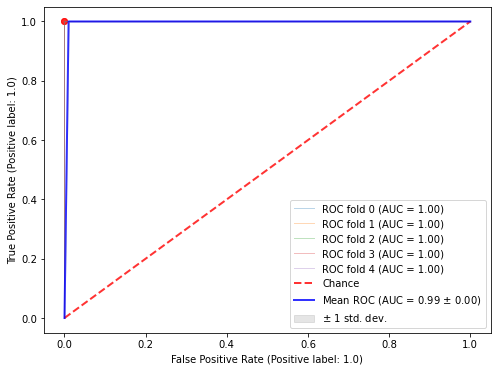

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9933     ,    0.9677     ,    0.9921     ,    0.8824     ,    0.9231     
  0  ,    0.9933     ,    0.9677     ,    0.9921     ,    0.8824     ,    0.9231     
  1  ,    0.9766     ,    0.9667     ,    0.9761     ,    0.6744     ,    0.7945     
  1  ,    0.9983     ,    0.9333     ,    0.9952     ,    0.9655     ,    0.9492     
  2  ,    0.9967     ,    1.0000     ,    0.9968     ,    0.9375     ,    0.9677     
  2  ,    0.9967     ,    1.0000     ,    0.9968     ,    0.9375     ,    0.9677     
  3  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  3  ,    0.9950     ,    0.9667     ,    0.9936     ,    0.9062     ,    0.9355     
  4  ,    0.9766     ,    1.0000     ,    0.9777     ,    0.6818     ,    0.8108     
  4  ,    0.9916     ,    0.9667     ,    0.9904     ,    0.8529     ,

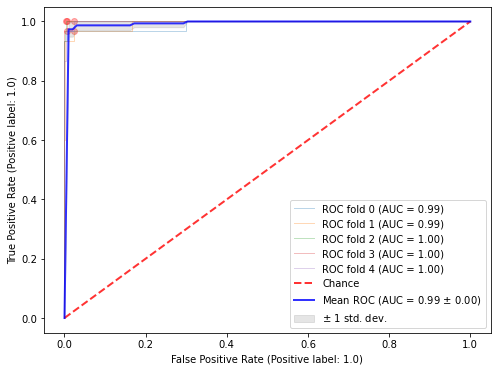

[0.9901283849390441, 0.9931438127090301, 0.9998327759197325, 0.9998327759197324, 0.9988851727982163]
0.9963645844571511
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9660     ,    0.9839     ,    0.9713     ,    0.9242     ,    0.9531     
  0  ,    0.9796     ,    0.9355     ,    0.9665     ,    0.9508     ,    0.9431     
  1  ,    1.0000     ,    0.9677     ,    0.9904     ,    1.0000     ,    0.9836     
  1  ,    0.9863     ,    0.9677     ,    0.9808     ,    0.9677     ,    0.9677     
  2  ,    0.9320     ,    1.0000     ,    0.9519     ,    0.8592     ,    0.9242     
  2  ,    0.9932     ,    0.8852     ,    0.9615     ,    0.9818     ,    0.9310     
  3  ,    0.9660     ,    1.0000     ,    0.9760     ,    0.9242     ,    0.9606     
  3  ,    0.9796     ,    0.9672     ,    0.9760     ,    0.9516     ,    0.9593     
  4  ,    0.9796     ,    0.9836     ,    0.9808     ,    0.9524  

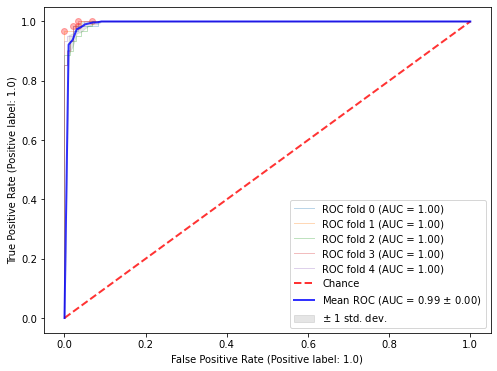

[0.9967083607636603, 0.9990057445868316, 0.9959852793576447, 0.9976580796252927, 0.9984387197501952]
0.9975592368167249
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.7500     ,    0.9762     ,    1.0000     ,    0.8571     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

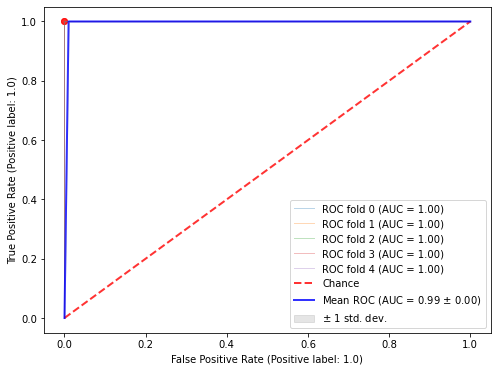

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9943     ,    0.9615     ,    0.9927     ,    0.8929     ,    0.9259     
  0  ,    1.0000     ,    0.9231     ,    0.9964     ,    1.0000     ,    0.9600     
  1  ,    0.9981     ,    1.0000     ,    0.9982     ,    0.9630     ,    0.9811     
  1  ,    1.0000     ,    0.8846     ,    0.9945     ,    1.0000     ,    0.9388     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9981     ,    1.0000     ,    0.9982     ,    0.9615     ,    0.9804     
  3  ,    0.9981     ,    0.9600     ,    0.9964     ,    0.9600     ,    0.9600     
  3  ,    1.0000     ,    0.9200     ,    0.9964     ,    1.0000     ,    0.9583     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    0.9200     ,    0.9964     ,    1.0000     ,

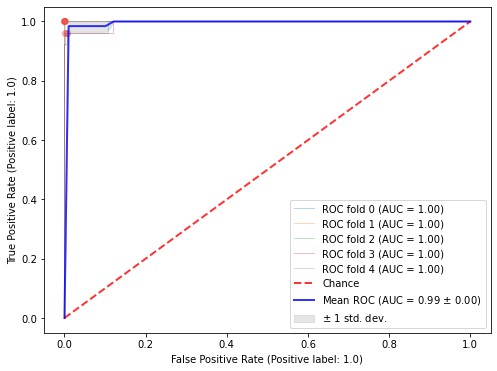

[0.99566112663627, 0.9999264597734961, 1.0, 0.9951145038167939, 1.0]
0.9981404180453121
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9928     ,    1.0000     ,    0.9933     ,    0.9184     ,    0.9574     
  0  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  1  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  1  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  2  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  2  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.

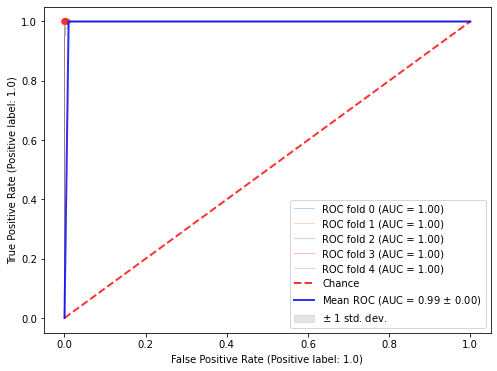

[0.9997997997997997, 0.99995995995996, 0.9999197753710389, 1.0, 1.0]
0.9999359070261598
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9969     ,    1.0000     ,    0.9972     ,    0.9661     ,    0.9828     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  2  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  3  ,    0.9969     ,    1.0000     ,    0.9972     ,    0.9655     ,    0.9825     
  3  ,    0.9985     ,    0.9821     ,    0.9972     ,    0.9821     ,    0.9821     
  4  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  4  ,    0.

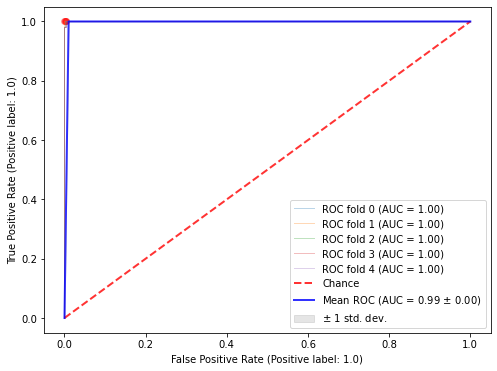

[0.9999458522850335, 1.0, 0.999972442680776, 0.999944885361552, 0.999972442680776]
0.9999671246016275
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9444     ,    0.9947     ,    1.0000     ,    0.9714     
  0  ,    0.9942     ,    0.9444     ,    0.9894     ,    0.9444     ,    0.9444     
  1  ,    0.9883     ,    1.0000     ,    0.9894     ,    0.9000     ,    0.9474     
  1  ,    0.9971     ,    0.9444     ,    0.9921     ,    0.9714     ,    0.9577     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  3  ,    0.9883     ,    0.9722     ,    0.9868     ,    0.8974     ,    0.9333     
  4  ,    0.9942     ,    0.8611     ,    0.9815     ,    0.9394     ,    0.8986    

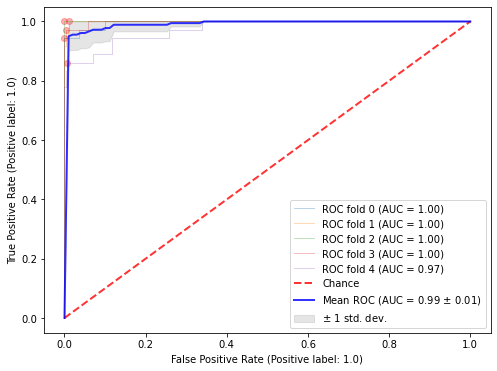

[0.9962638076673164, 0.9993502274204029, 1.0, 0.9982943469785576, 0.9746588693957116]
0.9937134502923977


In [11]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))